# HW3: Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Data Loading

<Axes: >

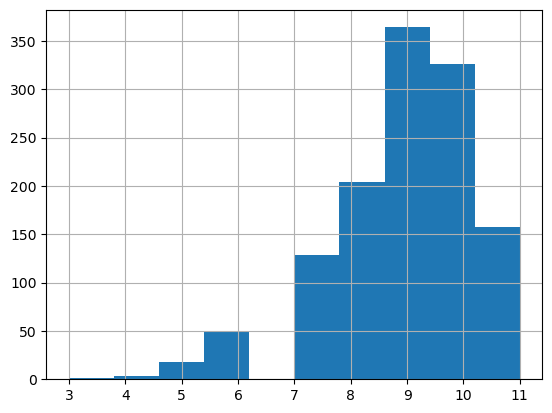

In [2]:
dataset = pd.read_csv("data_HW3.csv")
random_state = 17 + 75
train, test = train_test_split(dataset, test_size=0.2, random_state=random_state)

# dataset
dataset['happiness_score'].hist()


In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def prepare_data(training_data, new_data):
    new_data_prepared = new_data.copy()

    # fill missing values with median
    training_data = training_data.fillna({'PCR_02':training_data.PCR_02.median()})
    new_data_prepared = new_data_prepared.fillna({'PCR_02':training_data.PCR_02.median()})
    
    
    # scale the data
    scaler_standart = StandardScaler()
    scaler_minmax = MinMaxScaler(feature_range=(-1,1))

    temp_df_train_minmax = training_data[['PCR_01','PCR_03','PCR_04','PCR_06','PCR_08']]
    temp_df_train_standart = training_data[['happiness_score','PCR_02','PCR_05','PCR_07','PCR_09','PCR_10']]
    temp_df_new_minmax = new_data_prepared[['PCR_01','PCR_03','PCR_04','PCR_06','PCR_08']]
    temp_df_new_standart = new_data_prepared[['happiness_score','PCR_02','PCR_05','PCR_07','PCR_09','PCR_10']]

    scaler_minmax.fit(temp_df_train_minmax)
    scaler_standart.fit(temp_df_train_standart)

    new_data_prepared[['PCR_01','PCR_03','PCR_04','PCR_06','PCR_08']] = scaler_minmax.transform(temp_df_new_minmax)
    new_data_prepared[['happiness_score','PCR_02','PCR_05','PCR_07','PCR_09','PCR_10']] = scaler_standart.transform(temp_df_new_standart)

    return new_data_prepared

In [4]:
preprocessed_train = prepare_data(train, train)
preprocessed_test = prepare_data(train, test)

# Section 1: Linear regression implementation

## (Q1)

In [5]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model
    """
    def __init__(self, lr: float = 1e-5):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, X, y):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """

        # TODO: complete the loss calculation
        loss = None
        m = X.shape[0]
        b_vec = np.ones((m,))*b
        loss = 1/m * np.linalg.norm((X.dot(w) + b_vec)-y)**2

        return loss

    @staticmethod
    def gradient(w, b: float, X, y):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # TODO: calculate the analytical gradient w.r.t w and b
        g_w = None
        g_b = 0.0

        m = X.shape[0]
        b_vec = np.ones((m,))*b

        g_w = 2/m * (X.T).dot((X).dot(w) + b_vec - y)
        g_b = 2/m * (np.ones((m,)).T).dot((X).dot(w) + b_vec - y)

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                      X_val  =None, y_val = None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b, X, y))
            val_losses.append(self.loss(self.w, self.b, X_val, y_val))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # TODO: Compute the gradient for the current *batch*
            g_w, g_b = self.gradient(self.w, self.b, batch_X, batch_y)

            # Perform a gradient step
            # TODO: update the learned parameters correctly
            self.w = self.w - self.lr * g_w
            self.b = self.b - self.lr * g_b

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b,  X, y))
                val_losses.append(self.loss(self.w, self.b,  X_val, y_val))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """

        # TODO: Compute
        y_pred = X.dot(self.w) + self.b

        return y_pred

In [6]:
def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()


## (Q2)

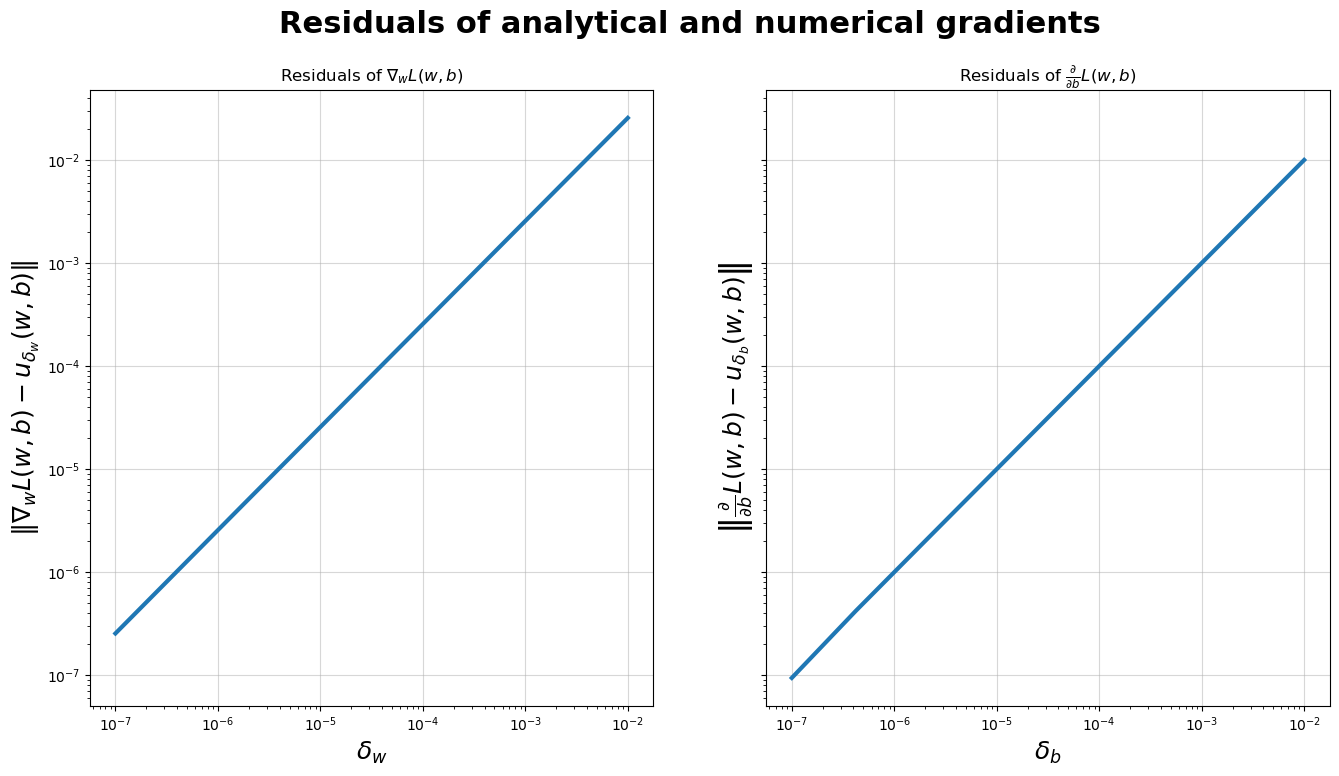

In [7]:
new_train, val = train_test_split(preprocessed_train, test_size=0.2, random_state=random_state)

X_train = np.array(new_train.drop(columns=['contamination_level']))
y_train = np.array(new_train['contamination_level'])

compare_gradients(X_train, y_train, deltas=np.logspace(-7, -2, 9))

## (Q3)

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def test_lr(X_train, y_train, X_val, y_val, title:str, max_iter = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5, top=0.9)
  
  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')

lr size = 1e-09, Best train loss = 4.935258720104657, Best validation loss = 4.856758713742074
lr size = 1e-08, Best train loss = 4.935133510028719, Best validation loss = 4.856637391838661
lr size = 1e-07, Best train loss = 4.933881783315424, Best validation loss = 4.855424525958928
lr size = 1e-06, Best train loss = 4.921401845213023, Best validation loss = 4.8433311123456875
lr size = 1e-05, Best train loss = 4.800260926394655, Best validation loss = 4.725852286066217
lr size = 0.0001, Best train loss = 3.8903743802388973, Best validation loss = 3.8367026440086462
lr size = 0.001, Best train loss = 2.6046552527503946, Best validation loss = 2.5020333782457174
lr size = 0.01, Best train loss = 2.584432890059838, Best validation loss = 2.460849805122371
lr size = 0.1, Best train loss = 2.611516189730902, Best validation loss = 2.4731854950498375


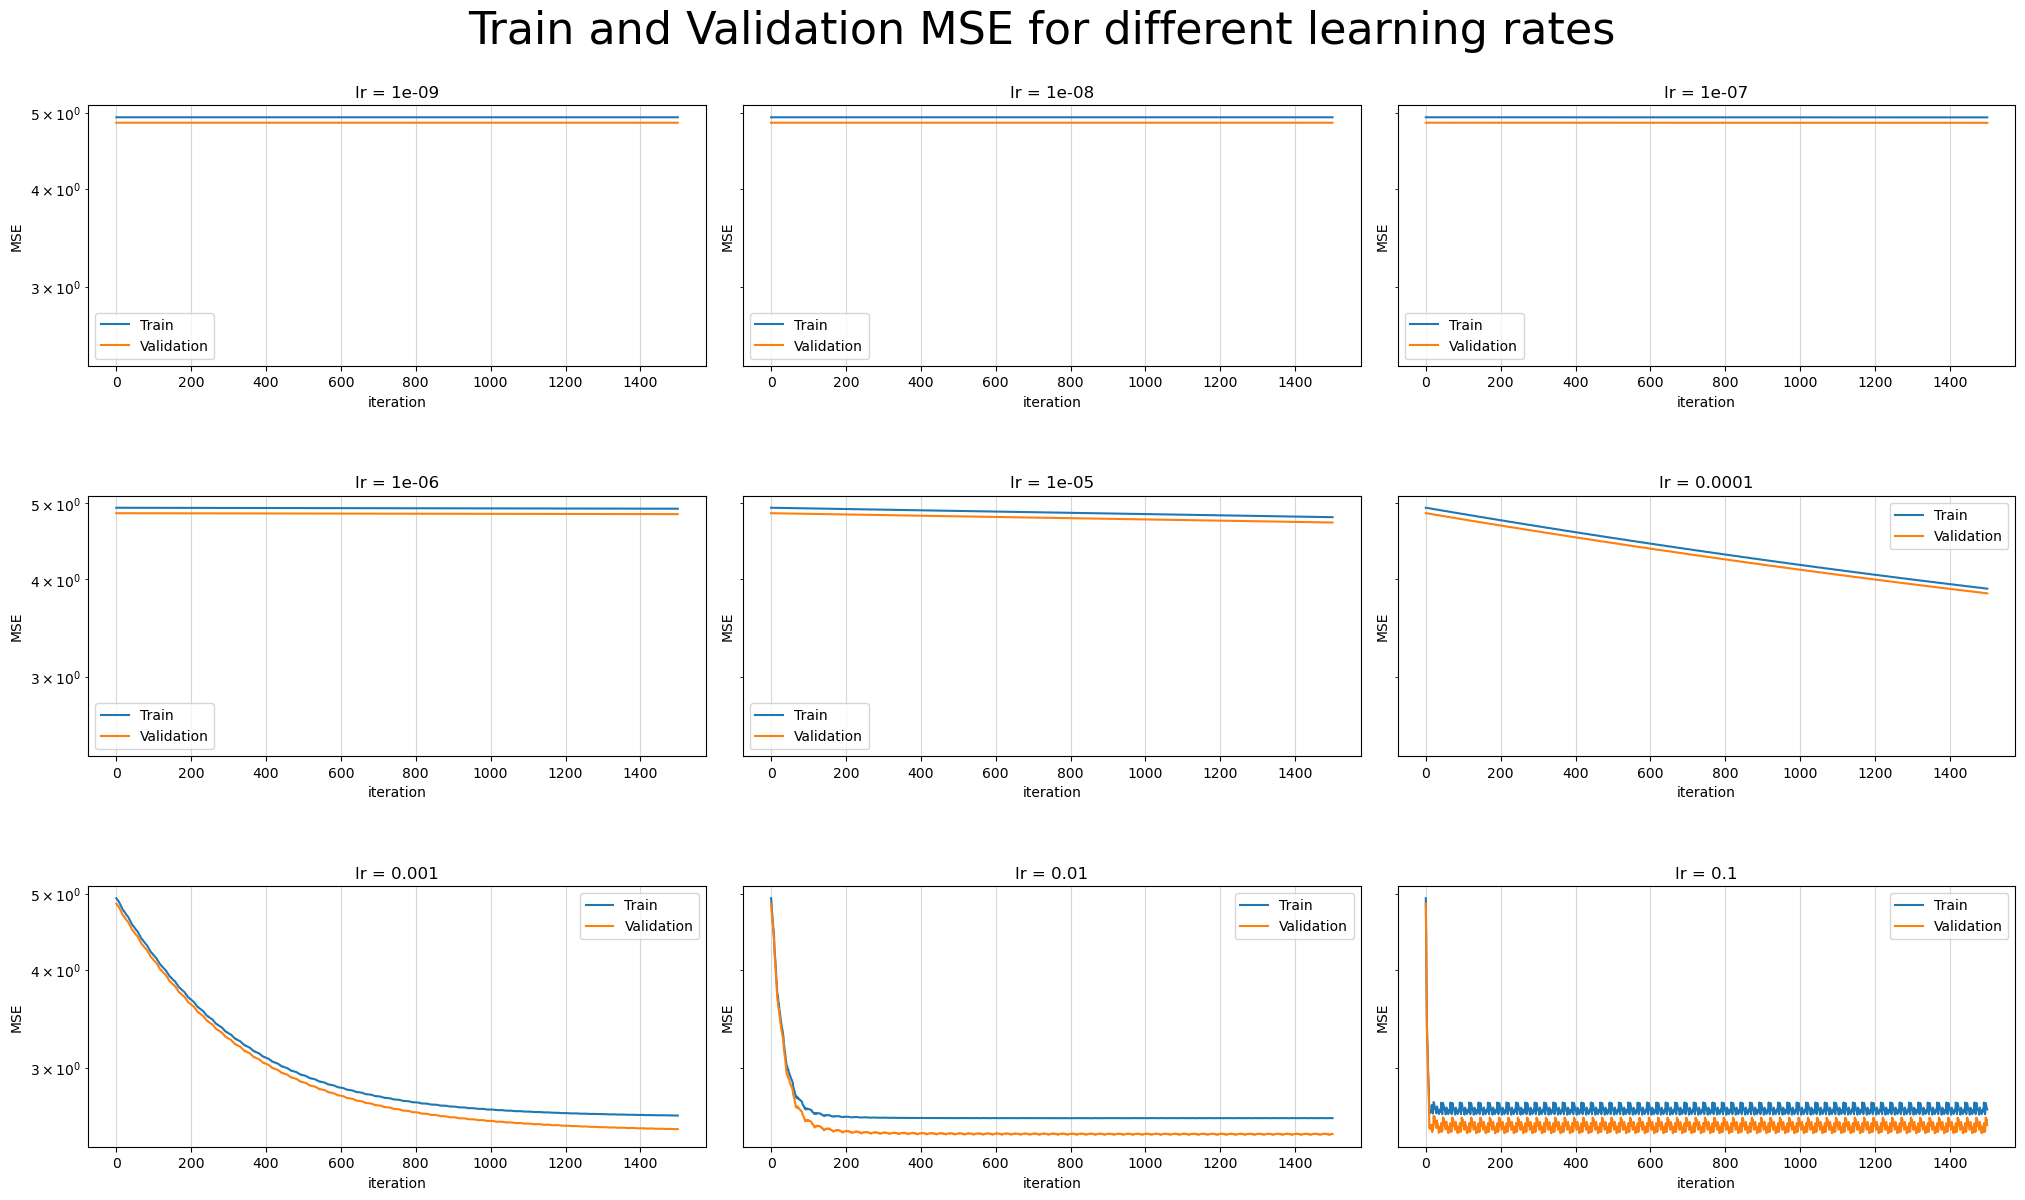

In [9]:
X_val = np.array(val.drop(columns=['contamination_level']))
y_val = np.array(val['contamination_level'])

test_lr(X_train, y_train, X_val, y_val,'Train and Validation MSE for different learning rates')

# Section 2: Evaluation and Baseline

## (Q4)

In [10]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate

dummy = DummyRegressor(strategy='mean')
X_train_all = np.array(preprocessed_train.drop(columns=['contamination_level']))
y_train_all = np.array(preprocessed_train['contamination_level'])
scores = cross_validate(dummy, X_train_all, y_train_all, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

test_avg = -np.mean(scores['test_score'])
train_avg = -np.mean(scores['train_score'])
print('Dummy model: train avg = '+str(train_avg)+', test avg = '+str(test_avg))


Dummy model: train avg = 3.7868001539351064, test avg = 3.793554926090078


In [11]:
dummy.fit(X_train_all, y_train_all)

DummyRegressor()

## (Q5)

In [12]:
lr_list = np.logspace(-7, -1, 7)
train_scores = []
validation_scores = []

for lr in lr_list:
    lin_regressor = LinearRegressor(lr)
    scores = cross_validate(lin_regressor, X_train_all, y_train_all, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    train_scores.append(-scores['train_score'].mean())
    validation_scores.append(-scores['test_score'].mean())


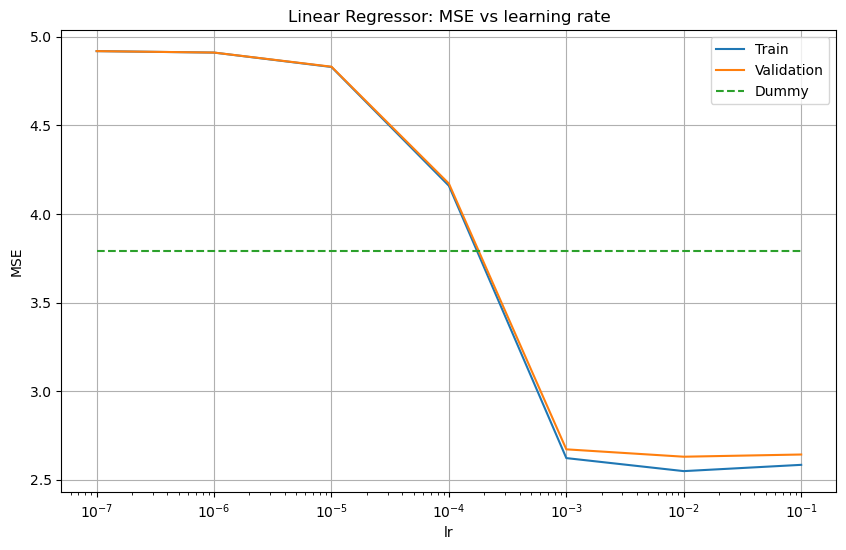

Best lr value is:  0.01
Mean train accuracy:  2.5486124177787017
Mean validation accuracy:  2.629930136116273


In [13]:
plt.figure(figsize=(10, 6))
plt.semilogx(lr_list, train_scores, label='Train')
plt.semilogx(lr_list, validation_scores, label='Validation')
plt.semilogx(lr_list, [test_avg]*len(lr_list), label='Dummy', linestyle='--')
plt.xlabel('lr')
plt.ylabel('MSE')
plt.title('Linear Regressor: MSE vs learning rate')
plt.grid(True)
plt.legend()
plt.show()

lr_ind = np.argmin(validation_scores)
lr_max = lr_list[lr_ind]
print("Best lr value is: ", lr_max)
print("Mean train accuracy: ", train_scores[lr_ind])
print("Mean validation accuracy: ", validation_scores[lr_ind])

In [14]:
best_lin_regressor = LinearRegressor(lr_max)
best_lin_regressor.fit(X_train_all, y_train_all)

LinearRegressor(lr=0.01)

# Section 3: Lasso linear regression

## (Q7)

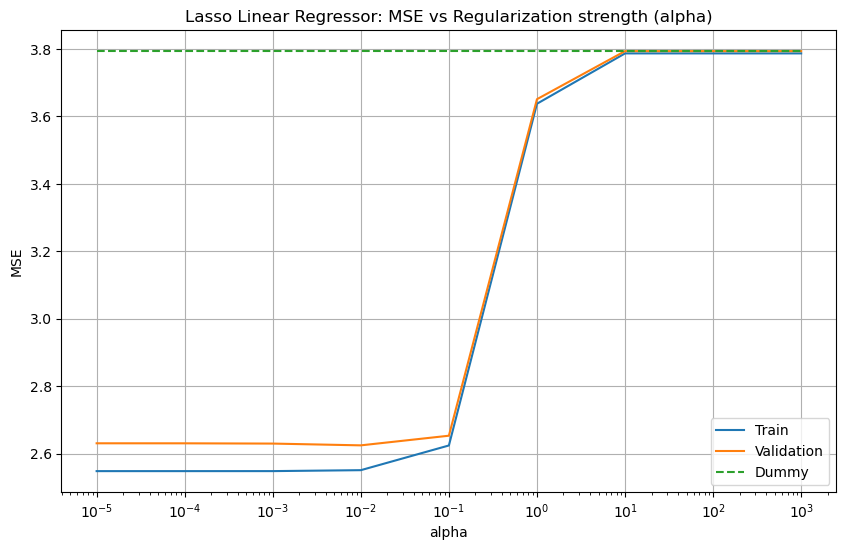

Best alpha value is:  0.01
Mean train accuracy:  2.5508393526481314
Mean validation accuracy:  2.6244428297704347


In [15]:
from sklearn.linear_model import Lasso

alpha_list = np.logspace(-5, 3, 9)
train_scores = []
validation_scores = []

for alpha in alpha_list:
    lasso_regressor = Lasso(alpha=alpha, fit_intercept=True)
    scores = cross_validate(lasso_regressor, X_train_all, y_train_all, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    train_scores.append(-scores['train_score'].mean())
    validation_scores.append(-scores['test_score'].mean())

plt.figure(figsize=(10, 6))
plt.semilogx(alpha_list, train_scores, label='Train')
plt.semilogx(alpha_list, validation_scores, label='Validation')
plt.semilogx(alpha_list, [test_avg]*len(alpha_list), label='Dummy', linestyle='--')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Lasso Linear Regressor: MSE vs Regularization strength (alpha)')
plt.grid(True)
plt.legend()
plt.show()

alpha_ind = np.argmin(validation_scores)
alpha_max = alpha_list[alpha_ind]
print("Best alpha value is: ", alpha_max)
print("Mean train accuracy: ", train_scores[alpha_ind])
print("Mean validation accuracy: ", validation_scores[alpha_ind])



In [16]:
best_lasso_regressor = Lasso(alpha=alpha_max, fit_intercept=True)
best_lasso_regressor.fit(X_train_all, y_train_all)

Lasso(alpha=0.01)

## (Q9)

In [17]:
print('Lasso coefficients: ', np.abs(best_lasso_regressor.coef_))
sorted_params = np.sort(np.abs(best_lasso_regressor.coef_))
sorted_params = sorted_params[::-1]
sorted_params_ind = np.argsort(np.abs(best_lasso_regressor.coef_))
sorted_params_ind = sorted_params_ind[::-1]
best_params_ind = sorted_params_ind[:5]
np.array(preprocessed_train.columns)[best_params_ind]


Lasso coefficients:  [1.07116325e+00 2.89890983e-02 8.00779058e-02 3.67222059e-01
 0.00000000e+00 4.51498553e-04 2.06788427e-01 2.99288292e-02
 1.51570688e-01 6.73712502e-03 4.52268943e-02]


array(['happiness_score', 'PCR_03', 'PCR_06', 'PCR_08', 'PCR_01'],
      dtype=object)

## (Q10)

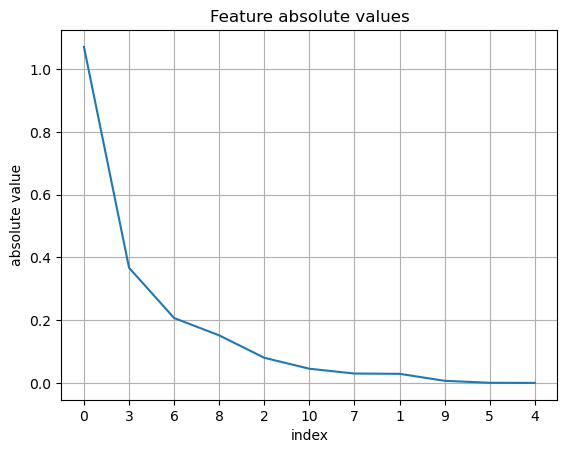

In [18]:
plt.plot(np.arange(len(sorted_params)), sorted_params)
plt.xticks(np.arange(0, len(sorted_params), step=1), labels=sorted_params_ind)
plt.xlabel('index')
plt.ylabel('absolute value')
plt.title('Feature absolute values')
plt.grid()

# Section 4: Polynomial fitting (visualization)

In [19]:
def plot3d(df, colX:str, colY:str, colZ:str, title:str, predictions=None):
  fig = plt.figure(figsize=(20, 7))
  axes = [fig.add_subplot(1, 3, i+1, projection='3d') for i in range(3)]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if predictions is not None:
      ax.scatter3D(df[colX], df[colY], predictions, color=palette[1], s=3)
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1, 
                   alpha=0.35, depthshade=False)
    else:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1)

    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    
    ax.view_init(elev=5., azim=45*i)
  
  axes[0].set_zlabel("\n" + colZ, linespacing=2.2)

  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  plt.show()

C:\Users\sherh\AppData\Local\Temp\ipykernel_12376\3733405945.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


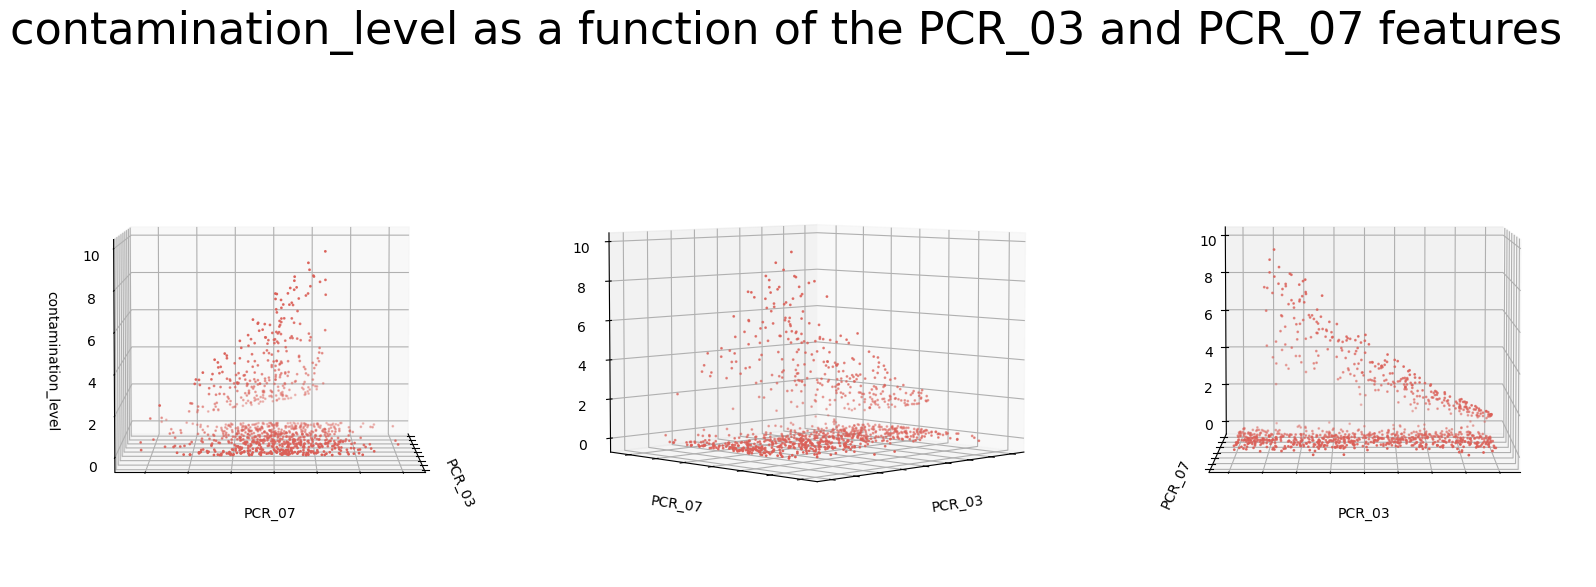

In [20]:

# X_train_pol = np.array(preprocessed_train[['PCR_03','PCR_07']])
X_train_pol = preprocessed_train[['PCR_03','PCR_07','contamination_level']]
plot3d(X_train_pol, 'PCR_03', 'PCR_07', 'contamination_level', 'contamination_level as a function of the PCR_03 and PCR_07 features')


In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

poly_reg = Pipeline([('feature_mapping', PolynomialFeatures(degree=3,)),
                    ('normalization', MinMaxScaler(feature_range=(-1,1))),
                    ('Lasso', Lasso(alpha=alpha_max, fit_intercept=True))])

X_train_pol_arr = np.array(X_train_pol.drop(columns=['contamination_level']))


## (Q15)

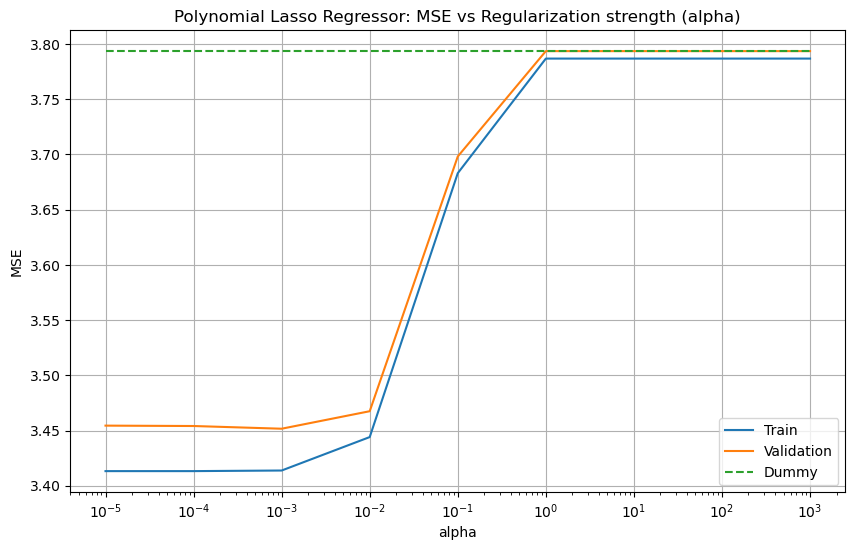

Best alpha value is:  0.001
Mean train accuracy:  3.413798528848818
Mean validation accuracy:  3.451641796202783


In [22]:
alpha_list_pol = np.logspace(-5, 3, 9)
train_scores = []
validation_scores = []

for alpha in alpha_list_pol:
    lasso_regressor = poly_reg.set_params(Lasso=Lasso(alpha=alpha, fit_intercept=True))
    scores = cross_validate(lasso_regressor, X_train_pol_arr, y_train_all, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    train_scores.append(-scores['train_score'].mean())
    validation_scores.append(-scores['test_score'].mean())

plt.figure(figsize=(10, 6))
plt.semilogx(alpha_list_pol, train_scores, label='Train')
plt.semilogx(alpha_list_pol, validation_scores, label='Validation')
plt.semilogx(alpha_list_pol, [test_avg]*len(alpha_list_pol), label='Dummy', linestyle='--')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Polynomial Lasso Regressor: MSE vs Regularization strength (alpha)')
plt.grid(True)
plt.legend()
plt.show()

alpha_pol_ind = np.argmin(validation_scores)
alpha_pol_max = alpha_list_pol[alpha_pol_ind]
print("Best alpha value is: ", alpha_pol_max)
print("Mean train accuracy: ", train_scores[alpha_pol_ind])
print("Mean validation accuracy: ", validation_scores[alpha_pol_ind])

In [23]:
lasso_pol_regressor = poly_reg.set_params(Lasso=Lasso(alpha=alpha_pol_max, fit_intercept=True))
lasso_pol_regressor.fit(X_train_pol_arr, y_train_all)

Pipeline(steps=[('feature_mapping', PolynomialFeatures(degree=3)),
                ('normalization', MinMaxScaler(feature_range=(-1, 1))),
                ('Lasso', Lasso(alpha=0.001))])

## (Q16)

C:\Users\sherh\AppData\Local\Temp\ipykernel_12376\3733405945.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


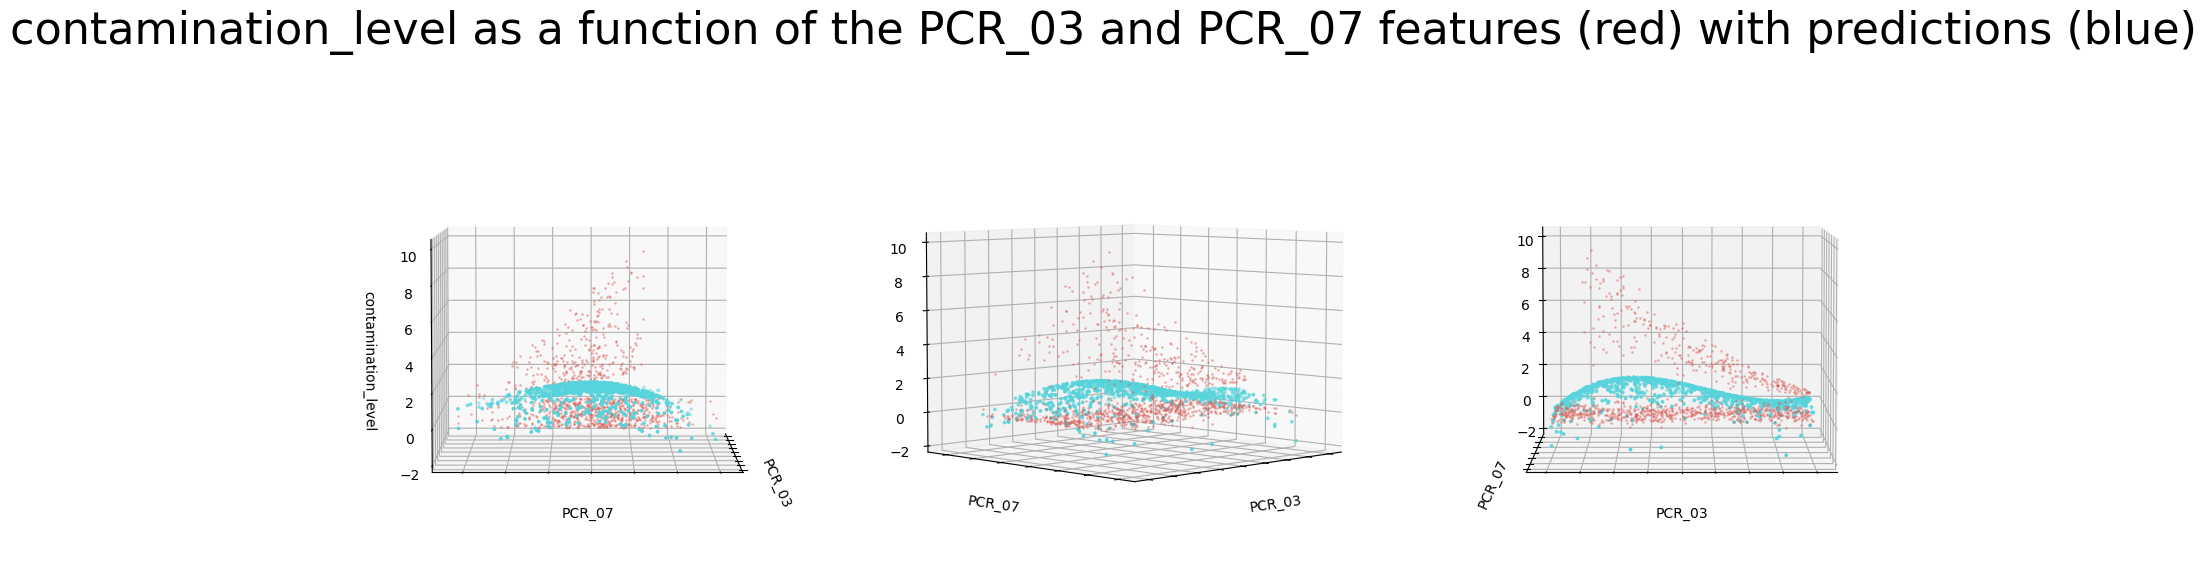

In [24]:
predictions = lasso_pol_regressor.predict(X_train_pol_arr)
plot3d(X_train_pol, 'PCR_03', 'PCR_07', 'contamination_level', 'contamination_level as a function of the PCR_03 and PCR_07 features (red) with predictions (blue)', predictions=predictions)


# Section 5: Fitting Gradient Boosted Machines (GBM) of the CovidScore

## (Q18)

In [25]:
best_params = np.array(preprocessed_train.columns)[best_params_ind]
X_train_gbm = np.array(preprocessed_train[best_params[:3]])

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor


lr_list = np.logspace(-5, 0, 6)
min_samples_range = range(5, 25)
param_grid = {'learning_rate': lr_list, 'min_samples_leaf': min_samples_range}

grid_search = GridSearchCV(GradientBoostingRegressor(loss='huber'), param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, error_score='raise')
grid_search.fit(X_train_gbm, y_train_all)



GridSearchCV(cv=5, error_score='raise',
             estimator=GradientBoostingRegressor(loss='huber'),
             param_grid={'learning_rate': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
                         'min_samples_leaf': range(5, 25)},
             return_train_score=True, scoring='neg_mean_squared_error')

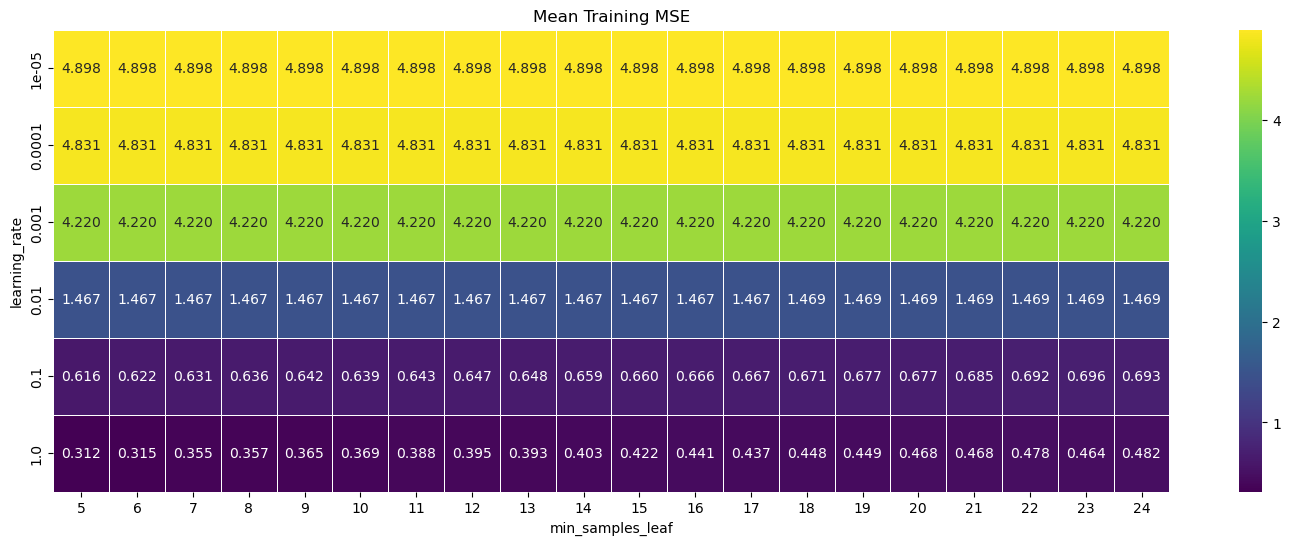

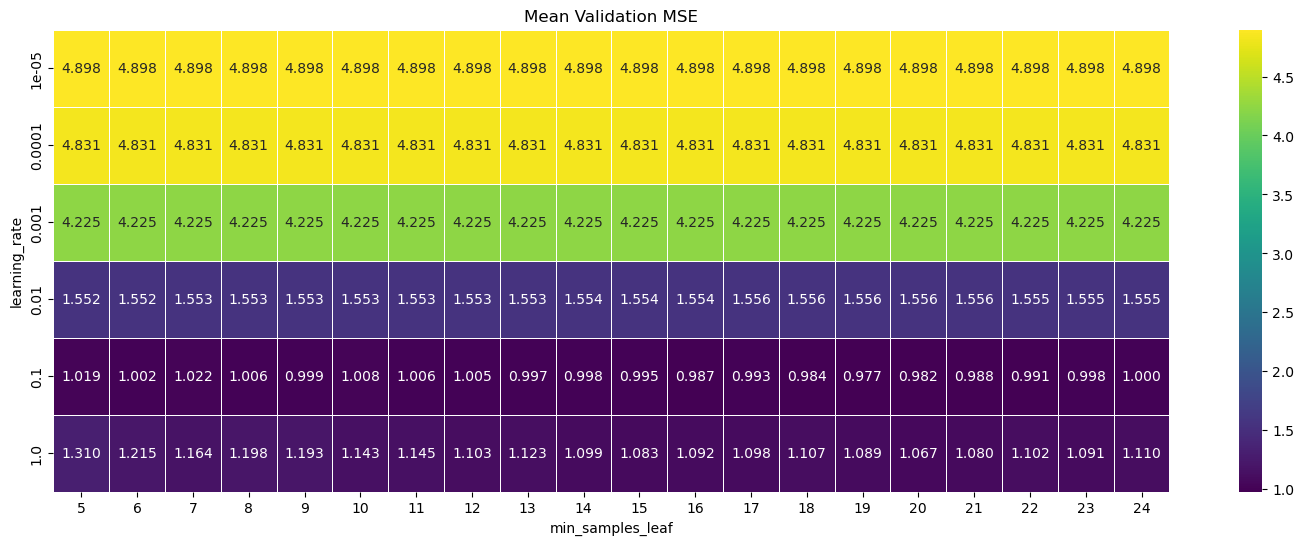

In [27]:
validation_acc_df = pd.DataFrame(grid_search.cv_results_['mean_test_score'].reshape(len(lr_list), len(min_samples_range)), index=lr_list, columns=min_samples_range)
train_acc_df = pd.DataFrame(grid_search.cv_results_['mean_train_score'].reshape(len(lr_list), len(min_samples_range)), index=lr_list, columns=min_samples_range)

plt.figure(figsize=(18, 6))
h = sns.heatmap(-train_acc_df, cmap='viridis', annot=True, fmt=".3f", linewidths=.5)
plt.title('Mean Training MSE')
plt.xlabel('min_samples_leaf')
plt.ylabel('learning_rate')
plt.show()
plt.figure(figsize=(18, 6))
h = sns.heatmap(-validation_acc_df, cmap='viridis', annot=True, fmt=".3f", linewidths=.5)
plt.title('Mean Validation MSE')
plt.xlabel('min_samples_leaf')
plt.ylabel('learning_rate')
plt.show()


In [28]:
best_GBM = GradientBoostingRegressor(learning_rate=0.1,min_samples_leaf=19, loss='huber')
best_GBM.fit(X_train_gbm, y_train_all)

GradientBoostingRegressor(loss='huber', min_samples_leaf=19)

# Section 6: Testing your models

In [29]:
from sklearn.metrics import mean_squared_error

X_test_all = np.array(preprocessed_test.drop(columns=['contamination_level']))
y_test_all = np.array(preprocessed_test['contamination_level'])
dummy.score(X_test_all, y_test_all)
dummy_predictions = dummy.predict(X_test_all)
mean_squared_error(y_test_all, dummy_predictions)

4.963184582611059

In [30]:
best_lin_regressor.score(X_test_all, y_test_all)
lin_predictions = best_lin_regressor.predict(X_test_all)
mean_squared_error(y_test_all, lin_predictions)

3.432713860684306

In [31]:
best_lasso_regressor.score(X_test_all, y_test_all)
lasso_predictions = best_lasso_regressor.predict(X_test_all)
mean_squared_error(y_test_all, lasso_predictions)

3.4284849115608202

In [32]:
X_test_pol = np.array(preprocessed_test[['PCR_03','PCR_07']])
lasso_pol_regressor.score(X_test_pol, y_test_all)
lasso_pol_predictions = lasso_pol_regressor.predict(X_test_pol)
mean_squared_error(y_test_all, lasso_pol_predictions)

4.264727012182619

In [33]:
X_test_gbm = np.array(preprocessed_test[best_params[:3]])
best_GBM.score(X_test_gbm, y_test_all)
gbm_predictions = best_GBM.predict(X_test_gbm)
mean_squared_error(y_test_all, gbm_predictions)

1.1241755994498537